# Spatial regression analysis with GANs: Generator

This notebook presents analysis on using GANs as a tool for spatial regression. Here, we focus on the Generator model $G$ and investigate several questions:

* can we use a trained Generator model $G$ to estimate gradients via backpropagation?
* can we estimate the spatial dependence of the gradient, i.e., the amount of "change" that stays in an originating region vs the "spillover" of that change outside the originating region?

# Packages

In [24]:
import numpy as np
import pandas as pd

import sys, os, time
import glob
import timeit

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable, grad
import torchvision.transforms as transforms

sys.path.append("../models/pytorch-CycleGAN-and-pix2pix/")

from models.models import create_model
from data.data_loader import CreateDataLoader
from util.visualizer import Visualizer
from pdb import set_trace as st
from util import html

sys.path.append("../pytorch_utils")
from loader_dataframe import ImageDataFrame, fn_rotate, grayscale_loader, default_loader

# Load model to analyze

#### Parse options file to load model parameters

In [6]:
def parse_value(v):
    try:
        v = float(v)
        if np.isinf(v):
            return v
        if np.round(v,0)==v:
            v = int(v)
        return v
    except:
        pass

    if v == 'False':
        return False
    elif v == 'True':
        return True
    elif '|' in v:
        v = v.split("|")
    elif v == '[]':
        v = []
    elif '[' in v:
        v = [int(x) if "'" not in x and '"' not in x else x.replace("'","").replace('"',"") \
             for x in v[1:-1].split(", ")]
    else:
        pass
    return v

from collections import namedtuple

def parse_opt_file(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [tuple(l.replace("\n","").split(': ')) for l in lines[1:-1]] 
    lines = [(x[0], parse_value(x[1])) for x in lines]
    ret = namedtuple("opt", [l[0].strip() for l in lines])
    for l in lines:
        setattr(ret, l[0], l[1])
    return ret

In [7]:
checkpoints_path = "/home/data/pytorch-workspace/urban-form-checkpoints/"

experiment_path = "pix2pix_reg_bceloss_af_nowater"

In [8]:
opt_filename = checkpoints_path + "checkpoints/" + experiment_path + "/opt.txt"

opt = parse_opt_file(opt_filename)
opt.checkpoints_dir = checkpoints_path + opt.checkpoints_dir
opt.batchSize = 1
if opt.label_columns == "":
    opt.label_columns = []
if hasattr(opt, 'cond_columns') and opt.cond_columns == "":
    opt.cond_columns = []
    
opt.nThreads = 1   # test code only supports nThreads=1
opt.batchSize = 1  #test code only supports batchSize=1
opt.serial_batches = True # no shuffle
# opt.gpu_ids = '-1'
opt.noise_amt = 0.01

#### Load models G and D

In [9]:
opt.phase = "test"
opt.which_epoch = '85'

model = create_model(opt)

model.load_network(model.netG, 'G', opt.which_epoch)

pix2pix-reg
---------- Networks initialized -------------
UnetGenerator (
  (model): UnetSkipConnectionBlock (
    (model): Sequential (
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): UnetSkipConnectionBlock (
        (model): Sequential (
          (0): LeakyReLU (0.2, inplace)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (3): UnetSkipConnectionBlock (
            (model): Sequential (
              (0): LeakyReLU (0.2, inplace)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
              (3): UnetSkipConnectionBlock (
                (model): Sequential (
                  (0): LeakyReLU (0.2, inplace)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (2

#### Set up data loaders

In [10]:
df = pd.read_csv(opt.dataroot + "train.csv").drop("Unnamed: 0", 1)
df.head(2)

,filename_SAR,class,country,population,city,region,source,build pct 128,patch distr 128,top patch areas 128,...,box counts 286,build pct 64,patch distr 64,top patch areas 64,fractal dim 64,box counts 64,decile,basename,index,filename_PNM
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,16525,"swansea, us (pop 16.5k)",Americas,SAR,0.064736,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.0, 9.0, 6.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",...,"[1.38629436, 2.19722458, 3.17805383, 4.2195077...",0.061183,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",1.396578,"[0.0, 1.38629436, 2.07944154, 2.99573227, 3.43...",7,"us_swansea,-us-(pop-16.5k)_very-small_16525_41...",12198,/home/data/world-cities/urban_areas_over_10kpo...
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,de,12299,"niefern oschelbronn, de (pop 12.3k)",Europe,SAR,0.102244,"[0.69314718, 0.0, 0.69314718, 0.0, 0.0, 0.0, 0...","[8.0, 5.0, 5.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, ...",...,"[1.38629436, 2.19722458, 3.21887582, 4.3944491...",0.100213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.696283,"[0.0, 1.38629436, 2.56494936, 3.52636052, 4.02...",9,"de_niefern-oschelbronn,-de-(pop-12.3k)_very-sm...",11861,/home/data/world-cities/urban_areas_over_10kpo...


In [12]:
df_val = pd.concat([df[(df['city'].str.contains('barcelona')) & (df['country']=='es') & (df['population']>500000)],
                    df[(df['city'].str.contains('san francisco')) & (df['country']=='us') & (df['population']>500000)],
                    df[(df['city'].str.contains('paris')) & (df['country']=='fr') & (df['population']>500000)],
                    df[(df['city'].str.contains('new delhi')) & (df['country']=='in') & (df['population']>500000)],
                    df[(df['city'].str.contains('boston')) & (df['country']=='us') & (df['population']>500000)]])
df_val.to_csv(opt.dataroot + "valid_sample.csv")

In [13]:
df_valid = pd.read_csv(opt.dataroot + "valid.csv").drop("Unnamed: 0", 1)
df_valid.rename(columns={"filename":"filename_SAR"}, inplace=True)
df_valid['filename_PNM'] = df_valid['filename_SAR'].apply(lambda x: x.replace("SAR", "PNM"))
df_valid.to_csv(opt.dataroot + "valid.csv")

In [14]:
df_valid.shape

(2996, 23)

In [21]:
opt.phase = 'all_sources'
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()

opt.phase = 'valid_sample'
data_loader_smpl = CreateDataLoader(opt)
dataset_smpl = data_loader_smpl.load_data()

opt.phase = 'valid'
data_loader_valid = CreateDataLoader(opt)
dataset_valid = data_loader_valid.load_data()

opt.phase = 'train'
data_loader_train = CreateDataLoader(opt)
dataset_train = data_loader_train.load_data()

opt.phase = "test"
data_loader_test = CreateDataLoader(opt)
dataset_test = data_loader_test.load_data()

visualizer = Visualizer(opt)


AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//all_sources.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//valid_sample.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//valid.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//train.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//test.csv
create web directory /home/data/pytorch-workspace/urban-form-checkpoints/./checkpoints/pix2pix_reg_bceloss_af_nowater/web...


In [16]:
opt.dataroot

'/home/data/world-cities/top10k-log/'

# Compare real and synthetic spatial statistics

In [ ]:
stats_df = []

for i, data in enumerate(dataset_train):
    clear_output(wait=True)
    print "%d"%(i)
    
    if i == 1000: break
    
    # perform forward pass using current data
    model.set_input(data)
    model.test()
    
    # extract model results
    imgA_path, imgB_path = model.get_image_paths()
    visuals = model.get_current_visuals()
    imgB_np = copy.copy(visuals['real_B'])
    imgB_np_fake = copy.copy(visuals['fake_B'])
    
    # compute labels of generated images
    labels_fake_true = compute_stats(imgB_np_fake[:,:,0], imgSize=256)
    labels_comp_true = compute_stats(imgB_np[:,:,0], imgSize=256)
    
    # get labels computed by Analyzer
    labels = model.get_current_labels()
    labels_fake_pred = labels['labels_fake'][0]
    labels_real_true = labels['labels']
    
    # add stats to list
    stats_df.append([imgA_path, imgB_path] + \
                    np.hstack([labels_fake_true, labels_fake_pred, labels_comp_true]).tolist())
                 
stats_df = pd.DataFrame(stats_df, 
                        columns=['filenameA', 'filenameB'] + ['a fake', 'f fake'] + 
                                [x+" pred" for x in opt.label_columns] + ['a real', 'f real'])

# # plot 

# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

# tips = sns.load_dataset("tips")
# ax = sns.regplot(x=stats_df['a real'], y=stats_df['build pct 286 pred'], x_bins=100)
# ax.set_xlabel("$a$")
# ax.set_ylabel("$\hat a$")

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

tips = sns.load_dataset("tips")
plt.figure(figsize=(4,4))
ax = sns.regplot(x=stats_df['a real'], y= stats_df['a fake'], x_bins=100)
ax.set_xlabel("$a$")
ax.set_ylabel("$\hat a$")
ax.set_title("Built area: \n synthetic ($\hat a$) vs true ($a$)")

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(4,4))
tips = sns.load_dataset("tips")
ax = sns.regplot(x=stats_df['f real'], y= stats_df['f fake'], x_bins=100)
ax.set_xlabel("$f$")
ax.set_ylabel("$\hat f$")
ax.set_title("Fractal dimension: \n synthetic ($\hat f$) vs true ($f$)")

In [ ]:
# sns.set_context("notebook", font_scale=1.3)

# g = sns.jointplot(stats_df['a real'], stats_df['f real'], 
#                   ylim=(1.8,2.0),
#                   kind="hex", color="#4CB391")
# g.fig.suptitle("Built area $a$ vs fractal dim. $f$ (real)", fontsize=16)
# g.ax_joint.set_xlabel("$a$")
# g.ax_joint.set_ylabel("$f$")

# sns.set_context("notebook", font_scale=1.3)

# g = sns.jointplot(stats_df['a fake'], stats_df['f fake'], 
#                   ylim=(1.8,2.0),
#                   kind="hex", color="#4CB391")
# g.fig.suptitle("Built area $\hat a$ vs fractal dim. $\hat f$ (pred.)", fontsize=16)
# g.ax_joint.set_xlabel("$\hat a$", fontsize=16)
# g.ax_joint.set_ylabel("$\hat f$", fontsize=16)

# Scenario analysis

### Estimate distance dependence of population density and luminosity

In [ ]:
which_dataset = dataset_valid
info_filename = data_loader_valid.filename_csv
info_df = pd.read_csv(info_filename)

dist_pop_mu = []
dist_lum_mu = []
dist_pop_se = []
dist_lum_se = []
patch_stats = []

start = timeit.default_timer()
for i, data in enumerate(which_dataset):

    AtoB = model.opt.which_direction == 'AtoB'
    imgA = data['A' if AtoB else 'B'].numpy()[0].transpose((1,2,0))
    imgB = data['B' if AtoB else 'A'].numpy()[0].transpose((1,2,0))
    path_PNM, path_SAR = data['A_paths' if AtoB else 'B_paths']
    path_PNM, path_SAR = path_PNM[0], path_SAR[0]
    city_name = os.path.basename(path_PNM).split("_")[2].replace("-", " ")
    info = info_df.iloc[i]
    
    if info['build pct 286'] < 0.01:
        continue
        
    # compute patch areas
    imgA = (imgA - imgA.min())/(imgA.max() - imgA.min()) * 255
    imgB = (imgB - imgB.min())/(imgB.max() - imgB.min()) * 255
    areas, mask = compute_patch_areas(imgB)
    _, regions = get_regions(imgB, patches=range(10))
    patch_sizes = np.array([len(r[0]) for r in regions])
    f_polycentr = sum(patch_sizes[2:]) / float(sum(patch_sizes[:2])) 
    patch_stats.append([city_name, info['region'], f_polycentr])

    # sample rays from city center: population
    theta_pop, rays_pop = extract_rays(imgA[:,:,0], imgA.shape[0]/2, imgA.shape[1]/2, step=10, n_samples=100)    
    rays_pop_mu = np.abs(rays_pop).mean(0); pop_scale = (rays_pop_mu.max() + 1e-5); 
    rays_pop_mu = rays_pop_mu / pop_scale
    rays_pop_se = np.abs(rays_pop).std(0); rays_pop_se = rays_pop_se / np.sqrt(pop_scale)
    dist_pop_mu.append(rays_pop_mu); dist_pop_se.append(rays_pop_se); 

    # sample rays from city center: luminosity
    theta_lum, rays_lum = extract_rays(imgA[:,:,1], imgA.shape[0]/2, imgA.shape[1]/2, step=10, n_samples=100)
    rays_lum_mu = np.abs(rays_lum).mean(0); lum_scale = (rays_lum_mu.max() + 1e-5)
    rays_lum_mu = rays_lum_mu / lum_scale
    rays_lum_se = np.abs(rays_lum).std(0); rays_lum_se = rays_lum_se / np.sqrt(lum_scale)    
    dist_lum_mu.append(rays_lum_mu); dist_lum_se.append(rays_lum_se); 

    stop = timeit.default_timer()
    clear_output(wait=True)
    print "%d / %d: %2.2f sec"%(i, len(info_df), stop-start)
    start = timeit.default_timer()

patch_stats = pd.DataFrame(patch_stats, 
                              columns=["city", "region", "pct polycenter"])
dist_pop_mu = np.vstack(dist_pop_mu)
dist_lum_mu = np.vstack(dist_lum_mu)

dist_pop_se = np.vstack(dist_pop_se)
dist_lum_se = np.vstack(dist_lum_se)

820 / 2996: 4.44 sec


In [76]:
# save profile data

with gzip.open(checkpoints_path + "/profile_stats_%s.pickle.gz"%opt.which_epoch, "w") as f:
    pickle.dump([dist_pop_mu, dist_pop_se, 
                 dist_lum_mu, dist_lum_se, 
                 patch_stats],f)

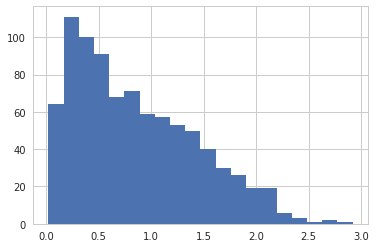

In [79]:
patch_stats['pct polycenter'].hist(bins=20)

In [67]:
len(dist_pop_mu)

871

### Estimate gradient magnitude relationship with distance 

In [ ]:
# which_dataset = dataset_smpl
# info_filename = data_loader_smpl.filename_csv

which_dataset = dataset_valid
info_filename = data_loader_valid.filename_csv

info_df = pd.read_csv(info_filename)

patches = [0] # main urban core
# patches = [1,2,3] # top 2 connected settlements

SHOW_PLOTS = False
N_GRAD_SMPL= 30

scenario_stats = []
grad_dist_pop_mu = []
grad_dist_lum_mu = []

grad_dist_pop_se = []
grad_dist_lum_se = []

start = timeit.default_timer()
for i, data in enumerate(which_dataset):
    if not SHOW_PLOTS:
        clear_output(wait=True)
        stop = timeit.default_timer()
        print "%d: %2.2f sec"%(i, stop-start)
        start = timeit.default_timer()

    AtoB = model.opt.which_direction == 'AtoB'
    imgA = data['A' if AtoB else 'B']
    imgB = data['B' if AtoB else 'A']
    path = data['A_paths' if AtoB else 'B_paths'][0]
    city_name = os.path.basename(path[0]).split("_")[2].replace("-", " ")
    info = info_df.iloc[i]
    
    if info['build pct 286'] < 0.01:
        continue
    
    # get patches for which to compute average gradient
    imgB_np = imgB.numpy()[0].transpose([1,2,0])
    imgB_np = (imgB_np+1)/(imgB_np.max()+1.0) * 255
    areas, mask = compute_patch_areas(imgB_np)
    _, regions = get_regions(imgB_np, patches=patches)
    
    region_x = []
    region_y = []
    for r in regions:
        region_x.append(r[0])
        region_y.append(r[1])
    region_x = np.hstack(region_x)
    region_y = np.hstack(region_y)
    idx      = np.random.choice(len(region_x), replace=False, 
                                size=min([len(region_x),N_GRAD_SMPL]))
    region   = (region_x[idx], region_y[idx])

    # run model, compute prediction and gradient
    model.set_input(data)
    img_path = model.get_image_paths()
    model.test()
    labels = model.get_current_labels()
    mygrad = model.compute_gradient(region=region)
    mygrad_np = mygrad.numpy()[0].transpose([1,2,0])
    
    if np.isnan(mygrad_np).sum() > 0:
        break
    
    # format images for display
    visuals = model.get_current_visuals()
    imgA_np = copy.copy(visuals['real_A'])
    imgB_np = copy.copy(visuals['real_B'])
    imgB_np_fake = copy.copy(visuals['fake_B'])
    
    grad_pop = mygrad_np[:,:,0]/ (np.abs(mygrad_np[:,:,0]).min() + 1e-5)
    grad_lum = mygrad_np[:,:,1]/ (np.abs(mygrad_np[:,:,1]).min() + 1e-5)

    # apply mask to regions of interest
    mymask = np.zeros(mask.shape)
    for i,p in enumerate(patches):
        a = areas[p]
        mymask[mask==a[0]] = i+1
    imgB_np[mymask>0] = 128
    
    # compute gradient within/without regions of interest
    norm_grad_pop_within  = np.abs(grad_pop[mymask[:,:,0]>0]).mean()
    norm_grad_pop_without = np.abs(grad_pop[mymask[:,:,0]==0]).mean()
    norm_grad_lum_within  = np.abs(grad_lum[mymask[:,:,0]>0]).mean()
    norm_grad_lum_without = np.abs(grad_lum[mymask[:,:,0]==0]).mean()
    scenario_stats.append((city_name, info['region'], 
                           norm_grad_pop_without/(norm_grad_pop_within+norm_grad_pop_without + 1e-5), 
                           norm_grad_lum_without/(norm_grad_lum_within+norm_grad_lum_without + 1e-5)))
    
    # sample gradient magnitude along random rays to study dependence with distance
    x0, y0 = regions[0][0].mean(), regions[0][1].mean()
    theta_pop, rays_pop = extract_rays(grad_pop, x0, y0, step=10, n_samples=100)    
    rays_pop_mu = np.abs(rays_pop).mean(0); pop_scale = (rays_pop_mu.max() + 1e-5); 
    rays_pop_mu = rays_pop_mu / pop_scale
    rays_pop_se = np.abs(rays_pop).std(0); rays_pop_se = rays_pop_se / np.sqrt(pop_scale)
    grad_dist_pop_mu.append(rays_pop_mu); grad_dist_pop_se.append(rays_pop_se); 
    
    theta_lum, rays_lum = extract_rays(grad_lum, x0, y0, step=10, n_samples=100)
    rays_lum_mu = np.abs(rays_lum).mean(0); lum_scale = (rays_lum_mu.max() + 1e-5)
    rays_lum_mu = rays_lum_mu / lum_scale
    rays_lum_se = np.abs(rays_lum).std(0); rays_lum_se = rays_lum_se / np.sqrt(lum_scale)    
    grad_dist_lum_mu.append(rays_lum_mu); grad_dist_lum_se.append(rays_lum_se); 
    
    if SHOW_PLOTS:
        fig, ax = plt.subplots(1,5, figsize=(16,4))

        ax[0].imshow(imgA_np)
        ax[1].imshow(imgB_np)
        ax[2].imshow(imgB_np_fake)
        ax[3].imshow(grad_pop)
        ax[4].imshow(grad_lum)

        titles = ["$x_A$ (Pop.+ Lum.)", "True map $x_B$", "Pred. map $\hat x_B$", 
                  "$\partial x_B/\partial x_{pop}$", "$\partial x_B/\partial x_{lum}$"]
        for i in range(5):
            ax[i].set_title(titles[i],  fontsize=16)
            ax[i].axis("off")

        fig.suptitle(city_name, fontsize=18)
        plt.subplots_adjust(top=1.0)
        plt.show()

scenario_stats = pd.DataFrame(scenario_stats, 
                              columns=["city", "region", "pct grad pop without", "pct grad lum without"])
grad_dist_pop_mu = np.vstack(grad_dist_pop_mu)
grad_dist_lum_mu = np.vstack(grad_dist_lum_mu)

grad_dist_pop_se = np.vstack(grad_dist_pop_se)
grad_dist_lum_se = np.vstack(grad_dist_lum_se)



In [ ]:
# save gradient data

with gzip.open(checkpoints_path + "/gradient_stats_%s.pickle.gz"%opt.which_epoch, "w") as f:
    pickle.dump([grad_dist_pop_mu, grad_dist_pop_se, 
                 grad_dist_lum_mu, grad_dist_lum_se, 
                 scenario_stats],f)

In [ ]:
# load pre-computed gradient data

with gzip.open(checkpoints_path + "/gradient_stats_%s.pickle.gz"%opt.which_epoch, "w") as f:
    (grad_dist_pop_mu, grad_dist_pop_se, grad_dist_lum_mu, grad_dist_lum_se, scenario_stats) = \
        pickle.load(f)

### Distribution of gradient magnitude within/without selected patches

In [ ]:
scenario_stats.dropna(inplace=True)
scenario_stats.head(3)

In [ ]:
scenario_stats.shape

In [ ]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats.rename(columns={"pct grad pop without":"$|\partial x_B/\partial x_{pop}|$ [%]"}),
                  col="region", margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{pop}|$ [%]")
plt.subplots_adjust(top=0.7)
g.fig.suptitle("Spatial gradient 'spillover': population density")

In [ ]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats.rename(columns={"pct grad lum without":"$|\partial x_B/\partial x_{lum}|$ [%]"}),
                  col="region", margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{lum}|$ [%]")
plt.subplots_adjust(top=0.7)
g.fig.suptitle("Spatial gradient 'spillover': relative luminance (energy)")

In [ ]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats[scenario_stats['region']!='Oceania']\
                      .rename(columns={"pct grad lum without":"$|\partial x_B/\partial x_{lum}|$ [%]"}),
                  col="region", col_wrap=2, margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{lum}|$ [%]")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Spatial gradient 'spillover': \n relative luminance (energy)")

### Study gradient dependence with distance from patch

In [ ]:
idx_ok = ~np.isnan(grad_dist_pop_mu.sum(1))
grad_dist_pop_df = pd.concat([scenario_stats[['city', 'region']], 
                              pd.DataFrame(grad_dist_pop_mu[idx_ok,:])], 1).dropna()

idx_ok = ~np.isnan(grad_dist_lum_mu.sum(1))
grad_dist_lum_df = pd.concat([scenario_stats[['city', 'region']], 
                              pd.DataFrame(grad_dist_lum_mu[idx_ok,:])], 1).dropna()

In [ ]:
paris_pop_dist = grad_dist_pop_df[grad_dist_pop_df['city'].str.contains("paris, fr ")]
paris_lum_dist = grad_dist_lum_df[grad_dist_lum_df['city'].str.contains("paris, fr ")]


In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(4,4))
plt.plot(np.arange(paris_lum_dist.shape[1]-2)*(10*200.0/256), 
         np.log10(paris_pop_dist.drop(["city", "region"],1).values.T), 
         label="pop. density", lw=3)
plt.plot(np.arange(paris_lum_dist.shape[1]-2)*(10*200.0/256), 
         np.log10(paris_lum_dist.drop(["city", "region"],1).values.T), 
         label="luminosity", lw=3)
plt.legend()
plt.ylabel("log $|\partial x_B/\partial x_A|(d)$ (norm.)")
plt.xlabel("Distance $d$ [km]")
plt.title("Paris: spatial gradient\n magnitude vs distance")

In [ ]:
grad_dist_pop_df_mlt = pd.melt(grad_dist_pop_df.iloc[:,:20], 
                               id_vars=["region", "city"])
grad_dist_pop_df_mlt['log value'] = grad_dist_pop_df_mlt['value'].apply(np.log10)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(12,4))
g = sns.boxplot(data=grad_dist_pop_df_mlt, hue="region",
                y="log value", x="variable", showfliers=False)
_ = g.set_xticklabels(((10*200./256)*np.arange(20)).astype(int), 
                      rotation=90)
g.set_xlabel("distance from patch $d$ [km]")
g.set_ylabel("log $|\partial x_B/\partial x_{pop}|$ (normalized)")
g.set_title("Distance dependence of spatial gradient: pop. density")

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(16,6))
g = sns.FacetGrid(grad_dist_pop_df_mlt, col="region", 
                  margin_titles=True, sharey=True)
g.map(sns.boxplot, "variable", "log value", showfliers=False)\
    .despine(left=True)
_ = g.set_xticklabels(((10*200./256)*np.arange(26)).astype(int), 
                      rotation=90)
g.set_xlabels("$d$ [km]")
g.set_ylabels("$log |\partial x_B/\partial x_{pop}|$ (norm.)")
g.fig.suptitle("Distance dependence of spatial gradient: pop. density")
plt.subplots_adjust(top=0.7)


In [ ]:
grad_dist_lum_df_mlt = pd.melt(grad_dist_lum_df.iloc[:,:20], 
                               id_vars=["region", "city"])
grad_dist_lum_df_mlt['log value'] = grad_dist_lum_df_mlt['value'].apply(np.log10)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(12,4))
g = sns.boxplot(data=grad_dist_lum_df_mlt, hue="region",
                y="log value", x="variable", showfliers=False)
_ = g.set_xticklabels(((10*200./256)*np.arange(20)).astype(int), 
                      rotation=90)
g.set_xlabel("distance from patch $d$ [km]")
g.set_ylabel("$|\partial x_B/\partial x_{lum}|$ (normalized)")
g.set_title("Distance dependence of spatial gradient: luminosity")

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(16,6))
g = sns.FacetGrid(grad_dist_lum_df_mlt, col="region", 
                  margin_titles=True, sharey=True)
g.map(sns.boxplot, "variable", "log value", showfliers=False)\
    .despine(left=True)
_ = g.set_xticklabels(((10*200./256)*np.arange(26)).astype(int), 
                      rotation=90)
g.set_xlabels("$d$ [km]")
g.set_ylabels("$|\partial x_B/\partial x_{lum}|$ (norm.)")
g.fig.suptitle("Distance dependence of spatial gradient: luminosity (energy)")
plt.subplots_adjust(top=0.7)
